In [2]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [3]:
SEGMENT_SIZE = 30
BINS_QUANTITY = 50
methods = {
    0: 'nk_ecg_peaks',
    1: 'swt_detector'
}

CHOOSE_METHOD = 1

In [6]:
n_bins = np.empty((0, BINS_QUANTITY + 1))

for db in ['AFIB', 'NSRDB', 'LTAFDB']:
    label = -1 if db == 'NSRDB' else 1
    
    rri_output = np.load(f"output/{methods[CHOOSE_METHOD]}/{db}.npy")

    rri_quantity = rri_output.shape[0]
    segments = []
    for i in range(0, rri_quantity, SEGMENT_SIZE):
        segment = rri_output[i:i+SEGMENT_SIZE]
        segments.append(segment.tolist())

    for segment in tqdm(segments):
        hist, edges = np.histogram(segment, bins=BINS_QUANTITY - 1)
        row = np.append(edges, label).reshape((1, BINS_QUANTITY + 1))
        n_bins = np.vstack((n_bins, row))

y = n_bins[:, -1]
X = n_bins[:, 0:-1]

np.save(f"output/{methods[CHOOSE_METHOD]}/X.npy", X)
np.save(f"output/{methods[CHOOSE_METHOD]}/y.npy", y)

(513173,)


(20000, 51)
(20000, 51)
0.750325


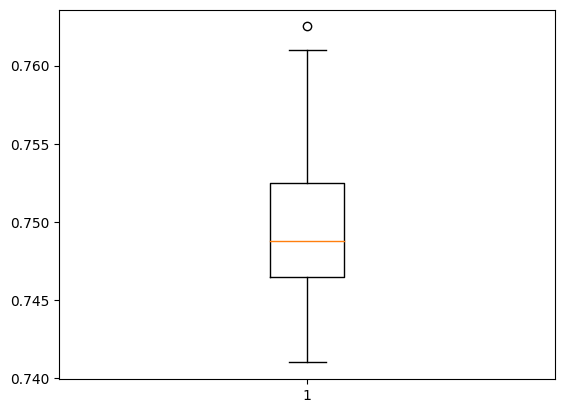

In [88]:
def get_random_samples(base, n_samples, label):
    samples = base[base[:, -1] == label]
    indexes = np.random.choice(samples.shape[0], n_samples, replace=False)
    return samples[indexes]


X = np.load(f'./output/{methods[CHOOSE_METHOD]}/X.npy')
y = np.load(f'./output/{methods[CHOOSE_METHOD]}/y.npy')
y = y.reshape(y.shape[0], 1)
base = np.hstack((X, y))

base_ready = np.vstack((get_random_samples(base, 10000, -1),
                        get_random_samples(base, 10000, -1)))

y = base_ready[:, -1]
X = base_ready[:, 0:-1]

clf_svm = SVC()
kfold = StratifiedKFold(n_splits=10)
cv_results = cross_val_score(clf_svm, X, y, cv=kfold, scoring='accuracy')
print(cv_results.mean())
plt.boxplot(cv_results)
plt.show()